##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Synthetic data

In [3]:
# TODO add a final completely random rotation element (same across whole
# measurement sequence) to represent the fact that we don't know where
# gravity is pointing relative to the sensor


def generate_stationary_noise(length):
    """Generate random normally distributed accelerometer measurements
    representing the noise experienced by a stationary sensor."""
    return np.random.normal(0, 1, (length, 3))


#def generate_linear_data(length):
#    """Generate normally distributed random data representing linear
#    acceleration along a vector, like a dumbbell squat."""
#    # TODO this doesn't look right
#    movement_vector = (np.random.random(3) - 0.5) * 2
#    movement_vectors = np.tile(movement_vector, (length, 1))
#    random_scalars = np.random.normal(0, 1, length)
#    angular_v = movement_vectors * random_scalars[:, None]
#    return angular_v

def generate_linear_data(length):
    pass


def generate_circular_data(length, radius=1, angle=2 * np.pi):
    """Generate acceleration data representing 2D circular motion,
    like a dumbbell curl."""
    # TODO also add the rising edge of the exercise

    # Generate x and y coordinates of an arc segment (no z yet)
    angular_v = np.zeros((length, 3))
    angular_v[:, 0] = radius * np.cos(np.linspace(0, angle, length))
    angular_v[:, 1] = radius * np.sin(np.linspace(0, angle, length))

    # Do some rotations to simulate the motion of a dumbbell curl
    # Rotate 0.53pi radians about z counterclockwise
    theta_z = -0.53 * np.pi
    R_z = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 1],
            [np.sin(theta_z), np.cos(theta_z), 0],
            [0, 0, 1],
        ]
    )

    # Flip about y
    theta_y = -np.pi
    R_y = np.array(
        [
            [np.cos(theta_y), 0, np.sin(theta_y)],
            [0, 1, 0],
            [-np.sin(theta_y), 0, np.cos(theta_y)],
        ]
    )

    R = np.dot(R_z, R_y)
    angular_v = np.dot(angular_v, R)

    return angular_v

### Synthetic dumbbell curl

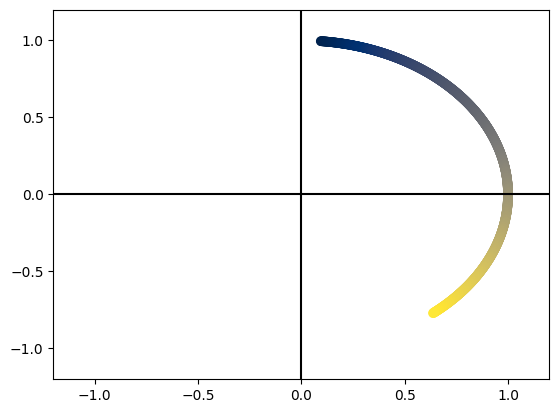

In [4]:
curl_down = generate_circular_data(1000, angle=0.75*np.pi)

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_down[:, 0], curl_down[:, 1], c=np.linspace(0, 1, len(curl_down)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

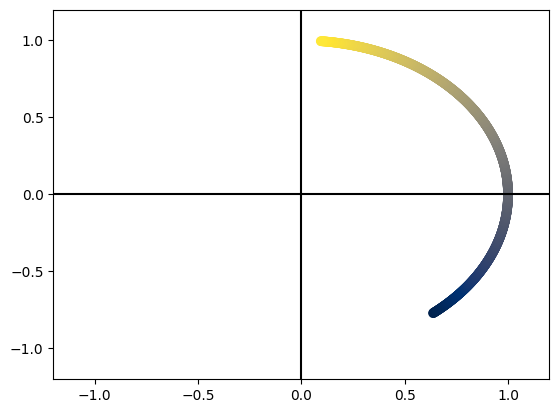

In [5]:
curl_up = curl_down[::-1, :]

# Four-quadrant XY plot
# Plot points in scatter wiht changing colour to indicate direction
plt.scatter(curl_up[:, 0], curl_up[:, 1], c=np.linspace(0, 1, len(curl_up)), cmap="cividis")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

/home/sam/.local/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


TypeError: 'NoneType' object is not subscriptable

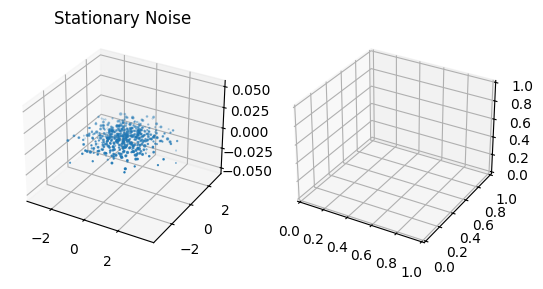

In [6]:
# Testing all three generation types
noise = generate_stationary_noise(1000)
linear = generate_linear_data(1000)
circular = generate_circular_data(1000, angle=0.5 * np.pi)
plt.subplot(1, 2, 1, projection="3d")
plt.scatter(noise[:, 0], noise[:, 1], noise[:, 2])
plt.title("Stationary Noise")
plt.subplot(1, 2, 2, projection="3d")
plt.scatter(linear[:, 0], linear[:, 1], linear[:, 2])
plt.title("Linear Acceleration")
plt.show()

### Synthetic squat

# Experiment

## Load data & true hypotheses

In [11]:
synth_df = pd.read_csv("./data/sam/synth_01.csv")
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x
0,1706201731199756500,0.252757,-7.177817,6.464345,0.991199
1,1706201731221438700,0.274439,-7.551312,6.133945,1.216254
2,1706201731237273900,0.290274,-7.771579,5.315128,1.273715
3,1706201731253591000,0.306591,-8.087613,5.238513,0.900220
4,1706201731263342000,0.316342,-8.240842,5.722142,1.297657
...,...,...,...,...,...
3307,1706201767173660000,36.226660,1.015141,7.513005,6.866570
3308,1706201767183247000,36.236247,1.015141,7.556100,7.144298
3309,1706201767193292000,36.246292,0.588974,7.513005,7.407660
3310,1706201767203083000,36.256083,0.378284,7.235278,6.971915


## Trim data to relevant periods

In [19]:
# Plot x, y and z values on a line for curl_df
def plot_accelerometer(df):
    fig = plt.figure(figsize=(50, 5))  
    fig.suptitle("Curls", fontsize=16)
    plt.subplot(1, 3, 1)
    plt.plot(df["x"], label="x")
    plt.plot(df["y"], label="y")
    ax = plt.plot(df["z"], label="z")

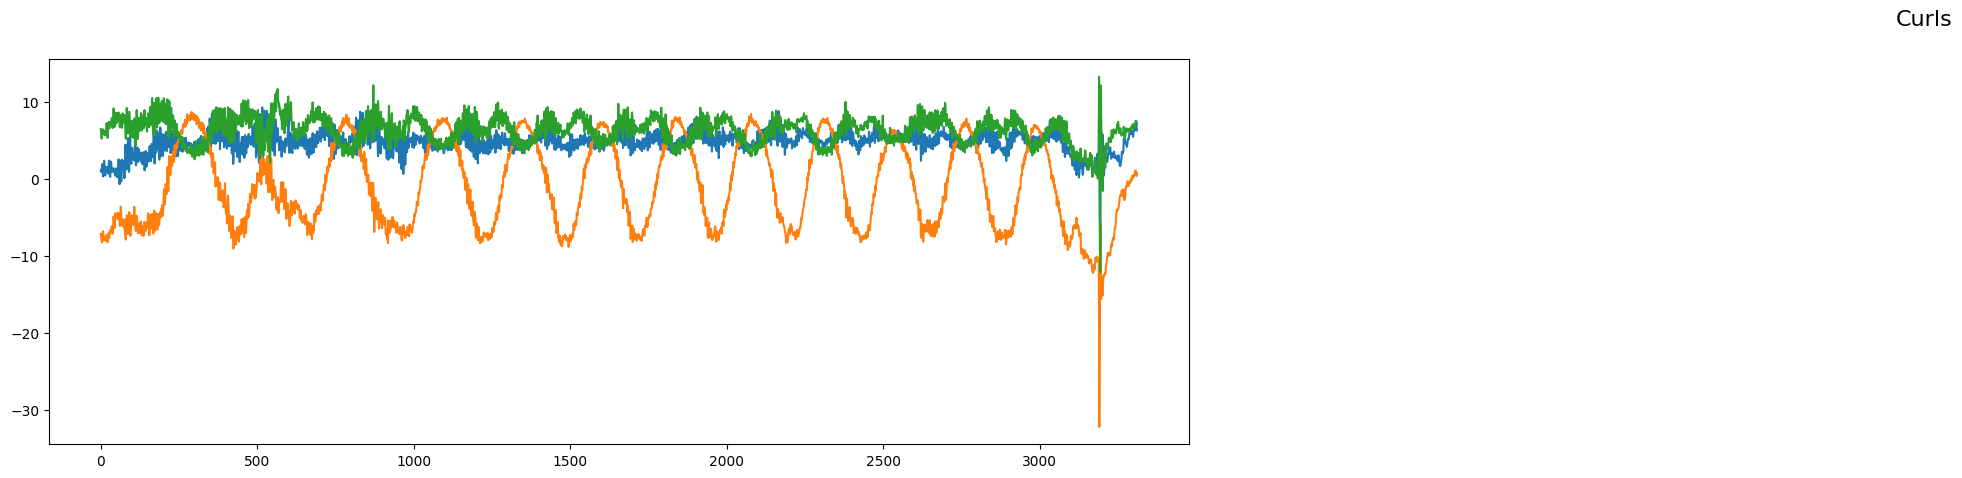

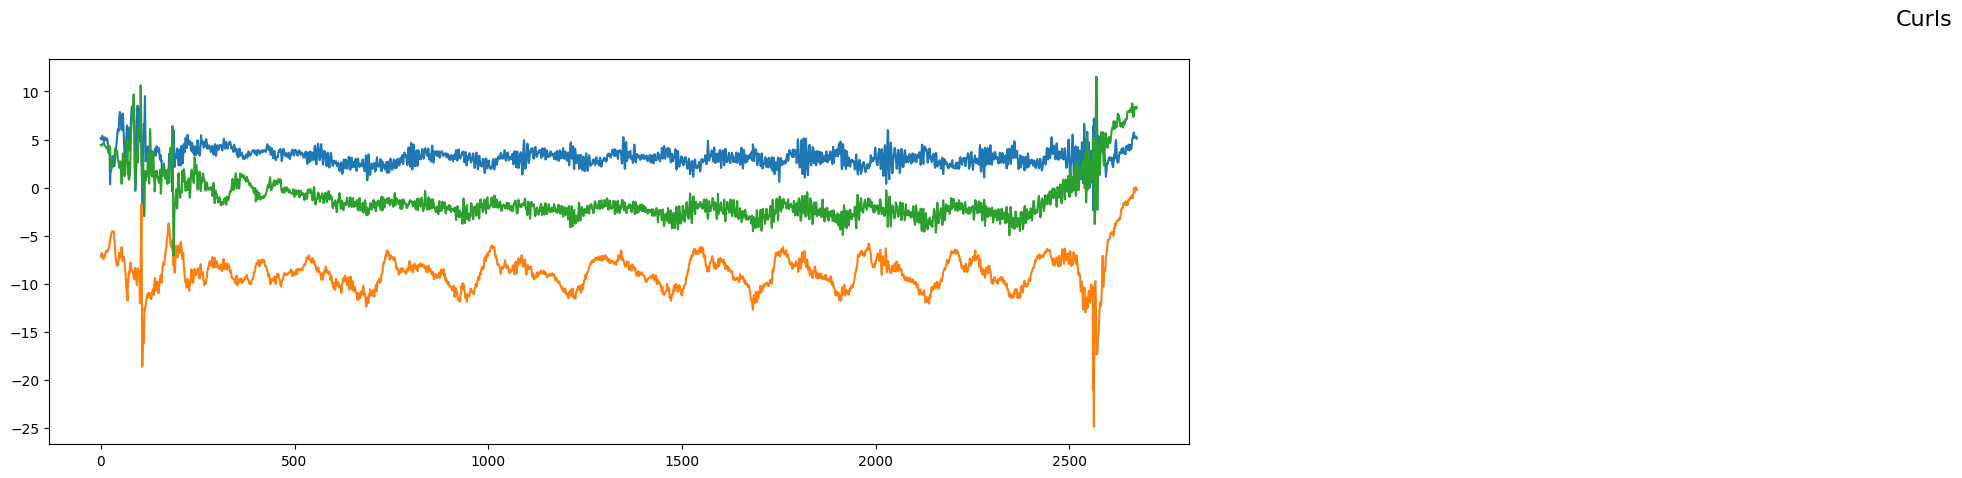

In [23]:
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

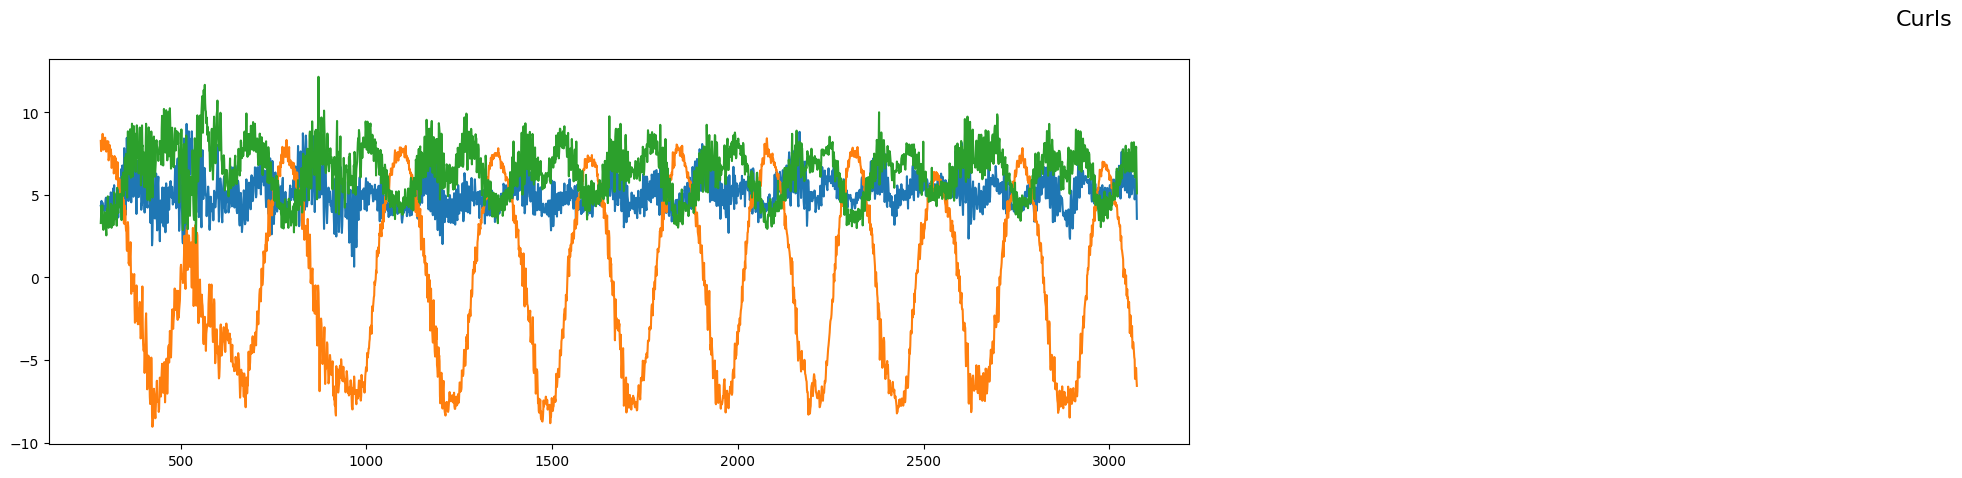

In [21]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 3.1466025390625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]
plot_accelerometer(curls_df_trim)

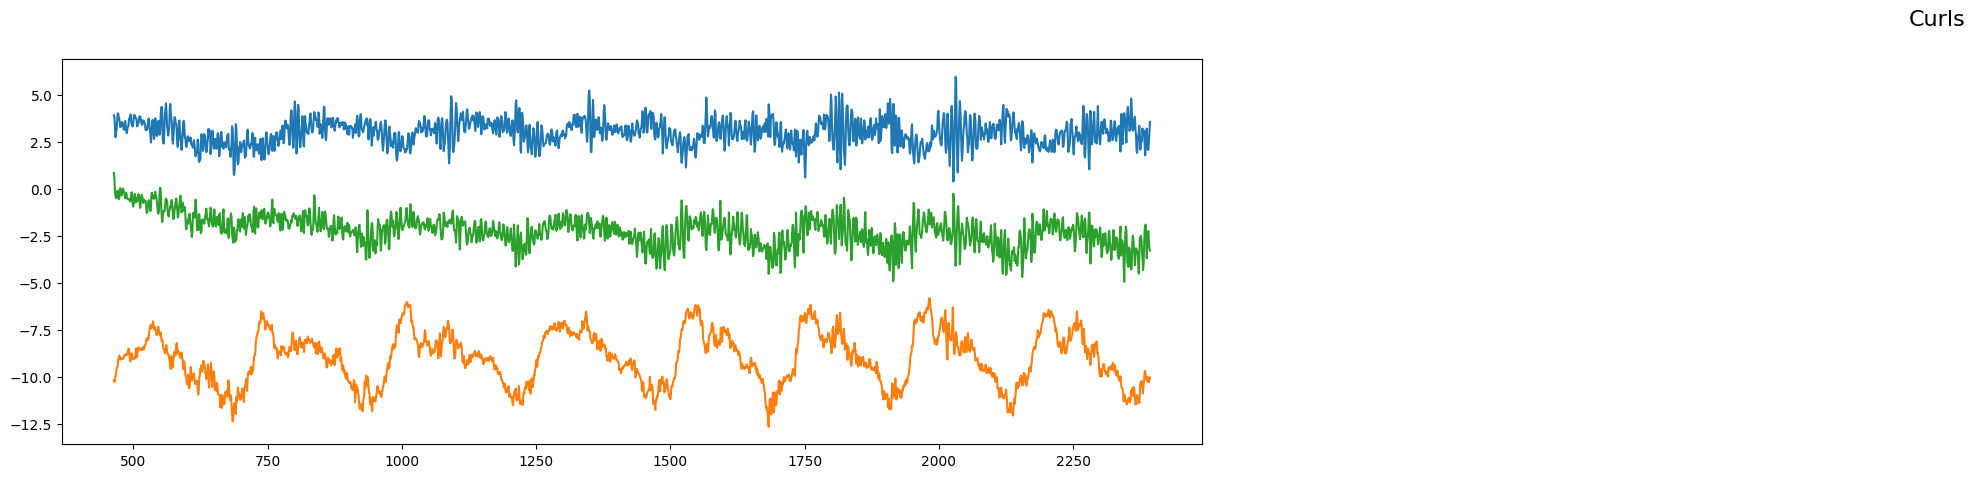

In [22]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
plot_accelerometer(squat_df_trim)

## Compute test statistics for data

In [24]:
def SSM(vector):
    """ Skew-symmetric vector such that something something (TODO) """
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def compute_test_statistics(measurements):
    Ts = []

    for measurement in measurements:
        M = SSM(measurement).T * SSM(measurement)
        eigs, _ = np.linalg.eig(M)
        min_eig = min(eigs)
        Ts.append(min_eig)

    return np.array(Ts)

In [25]:
# Compute test statistics for randomly generated values
measurements = np.random.rand(1000, 3)

Ts = compute_test_statistics(measurements)
Ts

array([-0.42142202, -0.52875818, -0.71551921, -0.24493019, -0.62206552,
       -0.58567888, -0.49210602, -0.20164554, -0.70726519, -0.25294792,
       -0.50236132, -0.73497737, -0.51032121, -0.45990519, -0.96499467,
       -0.09647247, -0.54761591, -0.39274452, -0.95194303, -0.77626248,
       -0.13866272, -0.70655755, -0.58404513, -0.1178564 , -0.89591822,
       -1.10268185, -0.85851725, -0.49160876, -0.1850661 , -0.53489367,
       -0.44192907, -0.19101054, -0.20656432, -0.35691113, -0.53659571,
       -0.40252156, -0.44334229, -0.11536388, -0.88686935, -0.98665566,
       -0.24664767, -0.57686585, -0.71352836, -1.06288245, -0.46900152,
       -0.98391269, -0.93722866, -0.67678414, -0.11187201, -0.17236671,
       -0.68105398, -0.45517706, -0.8963092 , -0.824278  , -0.80097525,
       -0.15743466, -0.55874721, -0.68354404, -0.35709187, -0.95229979,
       -0.89362141, -0.23155649, -1.06966637, -0.39646501, -0.35042057,
       -0.49834022, -0.09277685, -0.94601188, -0.61583842, -0.41

## Select threshold value $\gamma$ with best accuracy

In [10]:
# Grid search threshold
gammas = np.linspace(-5, 5, 100)

# Select the threshold that yields the best accuracy